In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model
import seaborn as sns
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
import statsmodels.formula.api as smf
import math

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
data = pd.read_csv("NYCrime.csv")
data.head(5)

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,"1,861",0,0,nan,0,0,0,12,2,10,0,0.000
1,Addison Town and Village,"2,577",3,0,nan,0,0,3,24,3,20,1,0.000
2,Akron Village,"2,846",3,0,nan,0,0,3,16,1,15,0,0.000
3,Albany,"97,956",791,8,nan,30,227,526,"4,090",705,"3,243",142,nan
4,Albion Village,"6,388",23,0,nan,3,4,16,223,53,165,5,nan


In [3]:
data.dtypes

City                                       object
Population                                 object
Violent\ncrime                             object
Murder and\nnonnegligent\nmanslaughter      int64
Rape\n(revised\ndefinition)1              float64
Rape\n(legacy\ndefinition)2                object
Robbery                                    object
Aggravated\nassault                        object
Property\ncrime                            object
Burglary                                   object
Larceny-\ntheft                            object
Motor\nvehicle\ntheft                      object
Arson3                                    float64
dtype: object

In [4]:
data.rename(columns={'City':'city','Population':'population','Violent\ncrime':'vCrime',
                   'Murder and\nnonnegligent\nmanslaughter':'murder','Rape\n(revised\ndefinition)1':'rapeRev',
                   'Rape\n(legacy\ndefinition)2':'rape','Robbery':'robbery','Aggravated\nassault':'assault',
                   'Property\ncrime':'pCrime','Burglary':'burglary','Larceny-\ntheft':'larceny',
                   'Motor\nvehicle\ntheft':'mTheft','Arson3':'arson'}, inplace=True)

In [5]:
data.head()

,city,population,vCrime,murder,rapeRev,rape,robbery,assault,pCrime,burglary,larceny,mTheft,arson
0,Adams Village,"1,861",0,0,nan,0,0,0,12,2,10,0,0.000
1,Addison Town and Village,"2,577",3,0,nan,0,0,3,24,3,20,1,0.000
2,Akron Village,"2,846",3,0,nan,0,0,3,16,1,15,0,0.000
3,Albany,"97,956",791,8,nan,30,227,526,"4,090",705,"3,243",142,nan
4,Albion Village,"6,388",23,0,nan,3,4,16,223,53,165,5,nan


In [6]:
data = data.replace(',','',regex = True)

In [7]:
data.head()

,city,population,vCrime,murder,rapeRev,rape,robbery,assault,pCrime,burglary,larceny,mTheft,arson
0,Adams Village,1861,0,0,nan,0,0,0,12,2,10,0,0.000
1,Addison Town and Village,2577,3,0,nan,0,0,3,24,3,20,1,0.000
2,Akron Village,2846,3,0,nan,0,0,3,16,1,15,0,0.000
3,Albany,97956,791,8,nan,30,227,526,4090,705,3243,142,nan
4,Albion Village,6388,23,0,nan,3,4,16,223,53,165,5,nan


In [8]:
data[['population','vCrime','rape','robbery','assault','pCrime','burglary','larceny','mTheft']] = data[['population','vCrime','rape','robbery','assault','pCrime','burglary','larceny','mTheft']].apply(pd.to_numeric)

In [9]:
data.dtypes

city           object
population      int64
vCrime          int64
murder          int64
rapeRev       float64
rape            int64
robbery         int64
assault         int64
pCrime          int64
burglary        int64
larceny         int64
mTheft          int64
arson         float64
dtype: object

In [10]:
data.describe()

,population,vCrime,murder,rapeRev,rape,robbery,assault,pCrime,burglary,larceny,mTheft,arson
count,348.000,348.000,348.000,0.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,187.000
mean,40037.632,201.595,1.566,nan,5.865,72.902,121.261,792.606,119.684,637.017,35.905,1.872
std,450037.368,2815.269,18.304,nan,60.425,1031.033,1706.132,7659.725,924.949,6346.054,403.424,10.693
min,526.000,0.000,0.000,nan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,3003.000,2.000,0.000,nan,0.000,0.000,1.000,40.500,6.000,31.000,0.000,0.000
50%,7233.500,6.000,0.000,nan,0.000,1.000,4.000,112.500,17.500,94.000,2.000,0.000
75%,18427.500,22.000,0.000,nan,2.000,5.000,14.000,341.000,51.250,287.250,7.000,1.000
max,8396126.000,52384.000,335.000,nan,1112.000,19170.000,31767.000,141971.000,16606.000,117931.000,7434.000,132.000


In [11]:
#Outliners are maximum in population. Let us keep it to 75th percentile
data = data[data.population < (np.percentile(data.population, 75))]

In [12]:
#Now things look ok
data.describe()

,population,vCrime,murder,rapeRev,rape,robbery,assault,pCrime,burglary,larceny,mTheft,arson
count,261.000,261.000,261.000,0.000,261.000,261.000,261.000,261.000,261.000,261.000,261.000,145.000
mean,6071.218,8.080,0.054,nan,0.705,1.632,5.690,119.345,19.226,97.736,2.383,0.345
std,4471.334,12.259,0.226,nan,1.598,3.025,8.593,140.709,23.494,118.640,3.822,0.861
min,526.000,0.000,0.000,nan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2381.000,1.000,0.000,nan,0.000,0.000,0.000,29.000,4.000,20.000,0.000,0.000
50%,4704.000,3.000,0.000,nan,0.000,0.000,3.000,66.000,11.000,53.000,1.000,0.000
75%,8544.000,9.000,0.000,nan,1.000,2.000,7.000,156.000,23.000,121.000,3.000,0.000
max,18182.000,89.000,1.000,nan,13.000,20.000,64.000,949.000,138.000,828.000,35.000,5.000


,population,vCrime,murder,rapeRev,rape,robbery,assault,pCrime,burglary,larceny,mTheft,arson
population,1.000,0.579,0.268,nan,0.421,0.560,0.543,0.663,0.634,0.644,0.538,0.467
vCrime,0.579,1.000,0.422,nan,0.799,0.818,0.979,0.796,0.833,0.759,0.628,0.493
murder,0.268,0.422,1.000,nan,0.300,0.350,0.397,0.298,0.315,0.280,0.346,0.232
rapeRev,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
rape,0.421,0.799,0.300,nan,1.000,0.561,0.749,0.667,0.673,0.640,0.526,0.341
robbery,0.560,0.818,0.350,nan,0.561,1.000,0.701,0.744,0.804,0.705,0.585,0.375
assault,0.543,0.979,0.397,nan,0.749,0.701,1.000,0.742,0.772,0.708,0.583,0.494
pCrime,0.663,0.796,0.298,nan,0.667,0.744,0.742,1.000,0.870,0.994,0.605,0.564
burglary,0.634,0.833,0.315,nan,0.673,0.804,0.772,0.870,1.000,0.814,0.616,0.524
larceny,0.644,0.759,0.280,nan,0.640,0.705,0.708,0.994,0.814,1.000,0.564,0.561


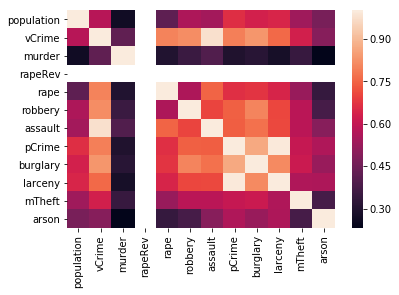

In [13]:
sns.heatmap(data.corr())
data.corr()

In [14]:
data.drop('rapeRev', axis=1, inplace=True)
data.drop('arson', axis=1, inplace=True)

,population,vCrime,murder,rape,robbery,assault,pCrime,burglary,larceny,mTheft
population,1.000,0.579,0.268,0.421,0.560,0.543,0.663,0.634,0.644,0.538
vCrime,0.579,1.000,0.422,0.799,0.818,0.979,0.796,0.833,0.759,0.628
murder,0.268,0.422,1.000,0.300,0.350,0.397,0.298,0.315,0.280,0.346
rape,0.421,0.799,0.300,1.000,0.561,0.749,0.667,0.673,0.640,0.526
robbery,0.560,0.818,0.350,0.561,1.000,0.701,0.744,0.804,0.705,0.585
assault,0.543,0.979,0.397,0.749,0.701,1.000,0.742,0.772,0.708,0.583
pCrime,0.663,0.796,0.298,0.667,0.744,0.742,1.000,0.870,0.994,0.605
burglary,0.634,0.833,0.315,0.673,0.804,0.772,0.870,1.000,0.814,0.616
larceny,0.644,0.759,0.280,0.640,0.705,0.708,0.994,0.814,1.000,0.564
mTheft,0.538,0.628,0.346,0.526,0.585,0.583,0.605,0.616,0.564,1.000


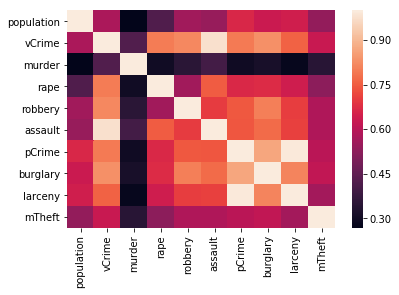

In [15]:
sns.heatmap(data.corr())
data.corr()

In [16]:
data = data.assign(popSq = data.population **2)
data = data.assign(murderC = np.where(data.murder>0,1,0))
data = data.assign(robberyC = np.where(data.robbery >0, 1,0))

In [17]:
#Property Crime has highest correlation with Larceny so let us model with it

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = data['pCrime'].values.reshape(-1, 1)
X = data['larceny'].values.reshape(-1, 1)
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[1.17926158]]

Intercept: 
 [4.08895173]

R-squared:
0.988644834351297


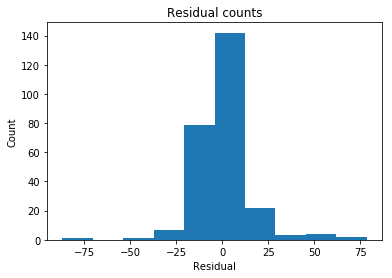

In [18]:
#Looks pretty good. Calculating multivariate normality

# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['pCrime']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

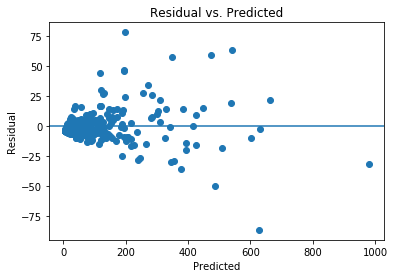

In [19]:
#Check Scedasticity

plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

#Looks like heteroscadastic.

In [20]:
# Take a subset of the data for PCA. they are the highest correlations after Larceny with Property crime. Also not included population 
data_pca = data[['vCrime','rape','robbery','assault','burglary','mTheft']]
X = StandardScaler().fit_transform(data_pca)

# The NumPy covariance function assumes that variables are represented by rows,
# not columns, so we transpose X.
Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

Covariance Matrix:
 [[1.00384615 0.80255434 0.82098184 0.98275055 0.83606464 0.63064583]
 [0.80255434 1.00384615 0.5627459  0.75225812 0.67603063 0.52805402]
 [0.82098184 0.5627459  1.00384615 0.70400785 0.80724109 0.58708863]
 [0.98275055 0.75225812 0.70400785 1.00384615 0.77459359 0.58571715]
 [0.83606464 0.67603063 0.80724109 0.77459359 1.00384615 0.61795939]
 [0.63064583 0.52805402 0.58708863 0.58571715 0.61795939 1.00384615]]


c:\users\bharath\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
c:\users\bharath\appdata\local\programs\python\python37\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [21]:
# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].reshape(1, 6).T
    print('Eigenvector {}: \n{}'.format(i + 1, eigvec_cov))
    print('Eigenvalue {}: {}'.format(i + 1, eig_val_cov[i]))
    print(40 * '-')

print(
    'The percentage of total variance in the dataset explained by each',
    'component calculated by hand.\n',
    eig_val_cov / sum(eig_val_cov)
)

Eigenvector 1: 
[[-0.45523155]
 [-0.38554558]
 [-0.40079377]
 [-0.43166209]
 [-0.42165496]
 [-0.34548246]]
Eigenvalue 1: 4.59122869931951
----------------------------------------
Eigenvector 2: 
[[-0.79576702]
 [ 0.10353684]
 [ 0.19874965]
 [ 0.56260267]
 [-0.00241097]
 [ 0.00244533]]
Eigenvalue 2: 0.00017515323317325007
----------------------------------------
Eigenvector 3: 
[[ 0.0897275 ]
 [ 0.23789549]
 [ 0.58677316]
 [-0.12748881]
 [-0.7578946 ]
 [ 0.01985841]]
Eigenvalue 3: 0.18179290960751546
----------------------------------------
Eigenvector 4: 
[[ 0.32768596]
 [-0.55405847]
 [-0.18702576]
 [ 0.62951272]
 [-0.38357979]
 [ 0.08510449]]
Eigenvalue 4: 0.251358881085859
----------------------------------------
Eigenvector 5: 
[[ 0.20563188]
 [ 0.43681887]
 [-0.20340065]
 [ 0.28551809]
 [-0.0650043 ]
 [-0.79986677]]
Eigenvalue 5: 0.543777703092806
----------------------------------------
Eigenvector 6: 
[[-0.04249127]
 [ 0.53502239]
 [-0.61580008]
 [ 0.05555032]
 [-0.31054476]
 [ 

In [22]:
# Create P, which we will use to transform Cx into Cy to get Y, the
# dimensionally-reduced representation of X.
P = eig_vec_cov[:, 0]

# Transform X into Y.
Y = P.T.dot(Xt)

data['Crime'] = Y


Coefficients: 
 [-55.69275278]

Intercept: 
 119.34482758620689

R-squared:
0.7192565117471532


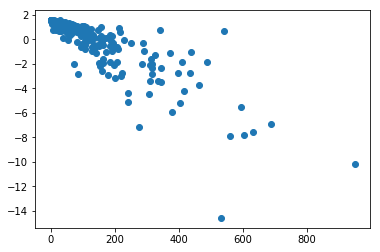

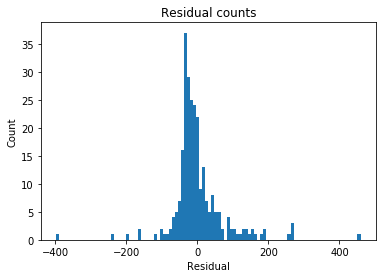

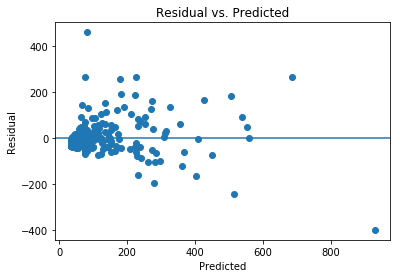

In [23]:
#Regression attempt with just this feature
regr = linear_model.LinearRegression()
Y = data['pCrime']
X = data[['Crime']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))
#check linearity
plt.scatter(data.pCrime, data.Crime)
plt.show()

#check multivariate normality
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['pCrime']

# Calculate the error, also called the residual.
residual = actual - predicted

#check multivariate normality
plt.hist(residual, bins=100)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

#check scedasticity
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [24]:
#Our residual is still not normally distributed. let's try to correct so that the larger cities have smaller errors and smaller
#cities have larger errors. 

#Create new feature that's defined as each population value over it's the mean of all of them
data['mean'] = [x / data.population.mean() for x in data['population']]
data.head()

,city,population,vCrime,murder,rape,robbery,assault,pCrime,burglary,larceny,mTheft,popSq,murderC,robberyC,Crime,mean
0,Adams Village,1861,0,0,0,0,0,12,2,10,0,3463321,0,0,1.500,0.307
1,Addison Town and Village,2577,3,0,0,0,3,24,3,20,1,6640929,0,0,1.128,0.424
2,Akron Village,2846,3,0,0,0,3,16,1,15,0,8099716,0,0,1.255,0.469
4,Albion Village,6388,23,0,3,4,16,223,53,165,5,40806544,0,1,-2.787,1.052
5,Alfred Village,4089,5,0,0,3,2,46,10,36,0,16719921,0,1,0.671,0.674



Coefficients: 
 [-46.73344223  41.6721126 ]

Intercept: 
 77.6727149897021

R-squared:
0.7482168303634076


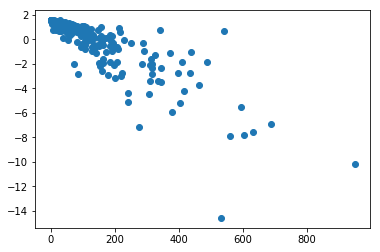

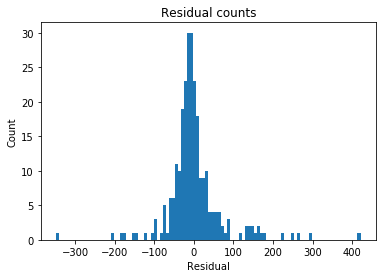

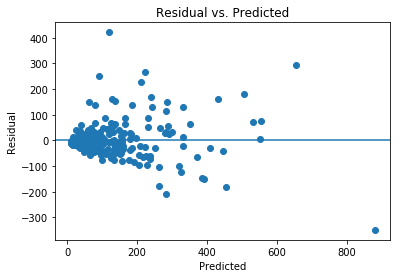

,Crime,mean
Crime,1.000,-0.626
mean,-0.626,1.000


In [25]:
# Try again using this feature as well as the original 6-crime PCA component
regr = linear_model.LinearRegression()
Y = data['pCrime']
X = data[['Crime', 'mean']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))
#check linearity
plt.scatter(data.pCrime, data.Crime)
plt.show()

#check multivariate normality
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['pCrime']

# Calculate the error, also called the residual.
residual = actual - predicted

#check multivariate normality
plt.hist(residual, bins=100)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

#check scedasticity
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()


#check multicollinearity
correlation_matrix = X.corr()
display(correlation_matrix)

In [26]:
#try regression with the PCA component and also the log of population
data['sqrtPop'] = [math.sqrt(x) for x in data['population']]
data.head()

,city,population,vCrime,murder,rape,robbery,assault,pCrime,burglary,larceny,mTheft,popSq,murderC,robberyC,Crime,mean,sqrtPop
0,Adams Village,1861,0,0,0,0,0,12,2,10,0,3463321,0,0,1.500,0.307,43.139
1,Addison Town and Village,2577,3,0,0,0,3,24,3,20,1,6640929,0,0,1.128,0.424,50.764
2,Akron Village,2846,3,0,0,0,3,16,1,15,0,8099716,0,0,1.255,0.469,53.348
4,Albion Village,6388,23,0,3,4,16,223,53,165,5,40806544,0,1,-2.787,1.052,79.925
5,Alfred Village,4089,5,0,0,3,2,46,10,36,0,16719921,0,1,0.671,0.674,63.945



Coefficients: 
 [-47.00168012   1.0962634 ]

Intercept: 
 39.68111527475514

R-squared:
0.7499096353023809


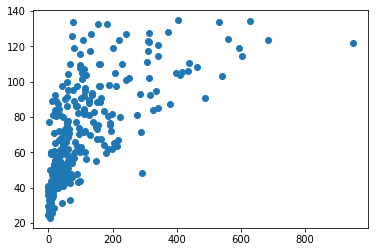

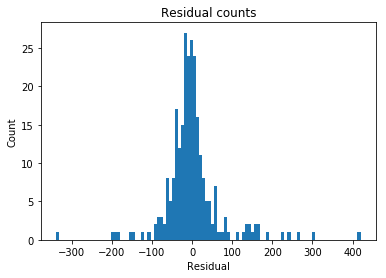

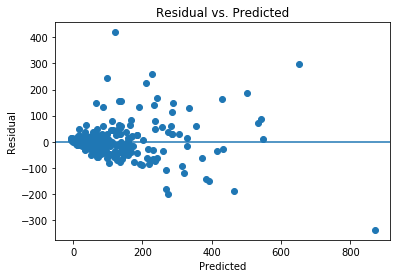

,Crime,sqrtPop
Crime,1.000,-0.603
sqrtPop,-0.603,1.000


In [27]:
# Try again using this feature as well as the original 6-crime PCA component
regr = linear_model.LinearRegression()
Y = data['pCrime']
X = data[['Crime', 'sqrtPop']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))
#check linearity
plt.scatter(data.pCrime, data.sqrtPop)
plt.show()

#check multivariate normality
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['pCrime']

# Calculate the error, also called the residual.
residual = actual - predicted

#check multivariate normality
plt.hist(residual, bins=100)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

#check scedasticity
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()


#check multicollinearity
correlation_matrix = X.corr()
display(correlation_matrix)

## Conclusion:

We see that Property Crime is best predicted by Larceny which is 98% accurate. I have not modeled around population since it is directly increases as population increases. But when I model with other highly correlated (corr >0.5) then I see that the accuracy comes down to approx 72%. But this combined with square root of population gives an accuracy of 75%